In [208]:
import importlib

import pandas as pd
import numpy as np

# Graphing
import graph_config
importlib.reload(graph_config)  # forces re-import
from graph_config import plt, set_spines



from pathlib import Path
import sys

NOTEBOOK_PATH = Path(__file__).resolve() if '__file__' in globals() else Path().resolve()

PROJECT_ROOT = NOTEBOOK_PATH.parent

# Define path to the dataset folder
RAW_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'raw'
PROCESSED_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'processed'

# Define path to output folder
FIGURES_PATH = PROJECT_ROOT / '04_outputs' / '01_figures'
TABLES_PATH = PROJECT_ROOT / '04_outputs' / '02_tables'

# Script paths
SCRIPTS_PATH = PROJECT_ROOT / '03_scripts'

# sys.path.append(str(SCRIPTS_PATH))

# from scrape_weather_data import weather_scraper

In [209]:
def load_data(filename):
    return pd.read_csv(RAW_DATASET_PATH / filename)

df_rd = load_data('Residential_demand.csv')

df_rd['Timestamp'] = pd.to_datetime(df_rd['Timestamp'])

print(f"residential demand shape: {df_rd.shape}")
df_rd.head()


residential demand shape: (17568, 3)


,Timestamp,Demand_mean_kw,N_households
0,2017-01-01 00:00:00,0.220106,5428
1,2017-01-01 00:30:00,0.205945,5429
2,2017-01-01 01:00:00,0.189090,5429
3,2017-01-01 01:30:00,0.173118,5429
4,2017-01-01 02:00:00,0.159051,5429


In [210]:
df_rd['Month_int'] = df_rd['Timestamp'].dt.month
df_rd['Date'] = df_rd['Timestamp'].dt.date
ts_rd = df_rd.set_index('Timestamp').copy()

ts_rd.head()

,Demand_mean_kw,N_households,Month_int,Date
Timestamp,,,,
2017-01-01 00:00:00,0.220106,5428,1,2017-01-01
2017-01-01 00:30:00,0.205945,5429,1,2017-01-01
2017-01-01 01:00:00,0.189090,5429,1,2017-01-01
2017-01-01 01:30:00,0.173118,5429,1,2017-01-01
2017-01-01 02:00:00,0.159051,5429,1,2017-01-01


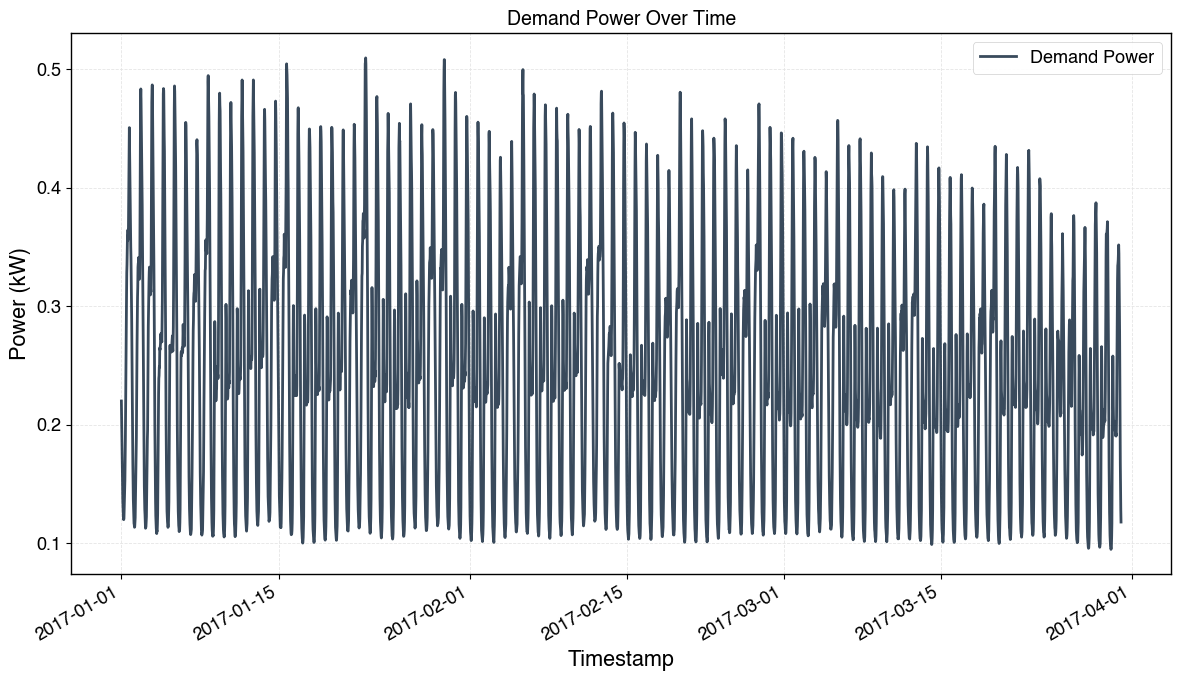

In [211]:
ts_rd_zoom = ts_rd[(ts_rd.index >= '2017-01-01') & (ts_rd.index <= '2017-03-31')]

fig, ax = plt.subplots(figsize=(12, 7))
set_spines(ax)
ax.plot(ts_rd_zoom.index, ts_rd_zoom['Demand_mean_kw'], label='Demand Power', alpha=0.8)
ax.set_title('Demand Power Over Time')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Power (kW)')
ax.legend()
ax.grid(True)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Data Cleaning

In [212]:
# Clip the number of household to 10,385 households
df_rd['N_households'] = df_rd['N_households'].clip(upper=10385)

# Time Series Analysis

## Decomposition

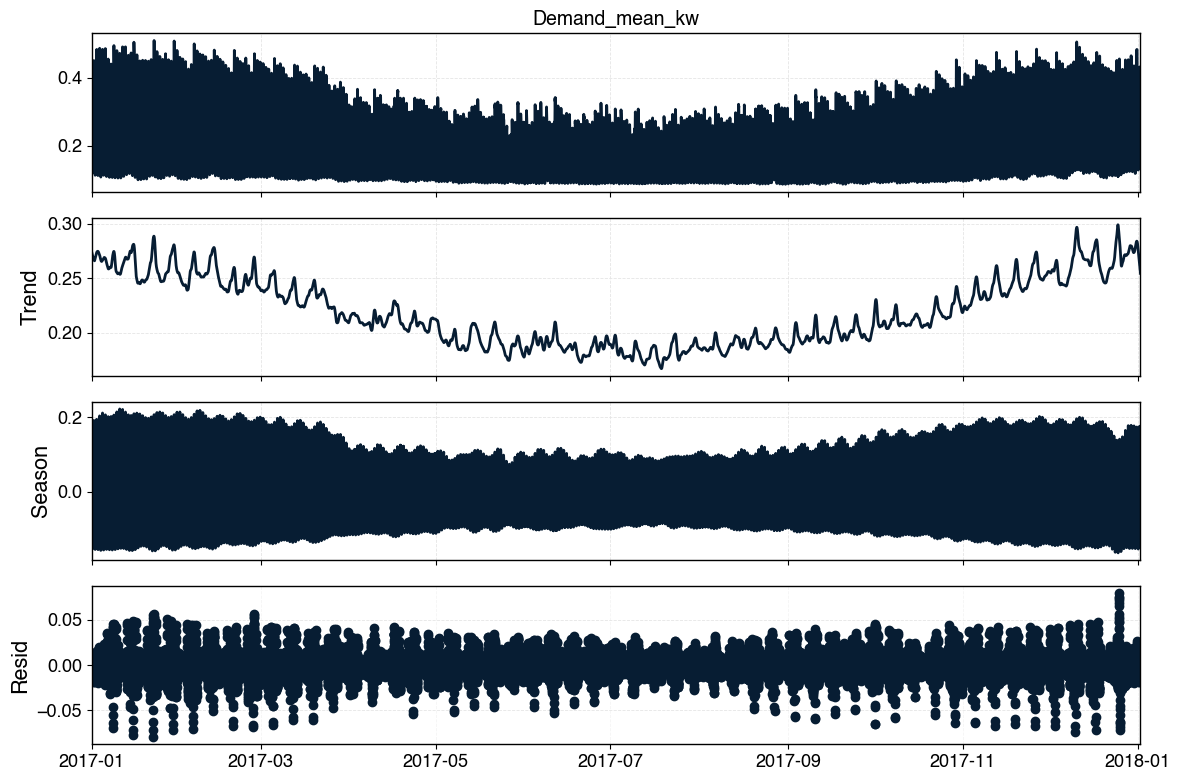

In [213]:
from statsmodels.tsa.seasonal import STL


stl = STL(ts_rd['Demand_mean_kw'], period=48)  # data is in 30-minute intervals, so period=48 for daily seasonality
res = stl.fit()

# Plot with custom size and layout
fig = res.plot()
fig.set_size_inches(12, 8)  # width, height in inches
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.show()


Since the data is from Orkney, Scotland, the pattern starts to make a lot more sense. Orkney has a cool and often windy climate, with long daylight hours in the summer and short, dark days in the winter. A lot of homes rely on electricity for heating and lighting, especially in rural areas where other energy options might be limited.

The increase demand around September probably marks the start of colder weather. People begin using electric heaters, lights, and maybe cooking indoors more often as the days get shorter.

The daily pattern also becomes more extreme later in the year. That’s likely because people use more electricity in the mornings and evenings when it's darker and colder outside. So the bigger daily swings in the seasonal component match what you’d expect for Orkney’s winter life—lights on earlier, heaters running longer, and more indoor activity overall.

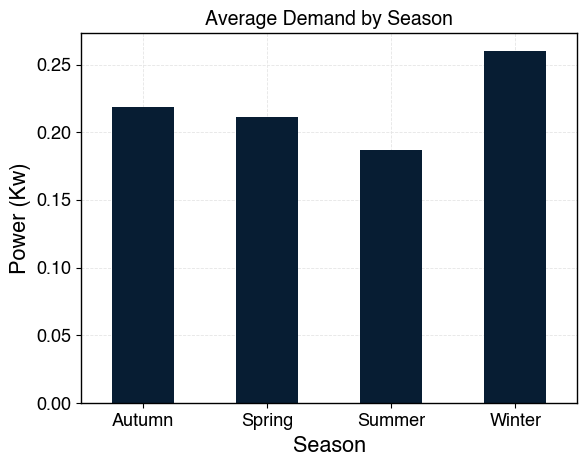

In [214]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

ts_rd['Season'] = ts_rd['Month_int'].apply(get_season)

ts_rd.groupby('Season')['Demand_mean_kw'].mean().plot(kind='bar', title='Average Demand by Season')
plt.ylabel('Power (Kw)')
set_spines(plt.gca())
#rotate x-axis labels for better readability
plt.xticks(rotation=0)
plt.show()

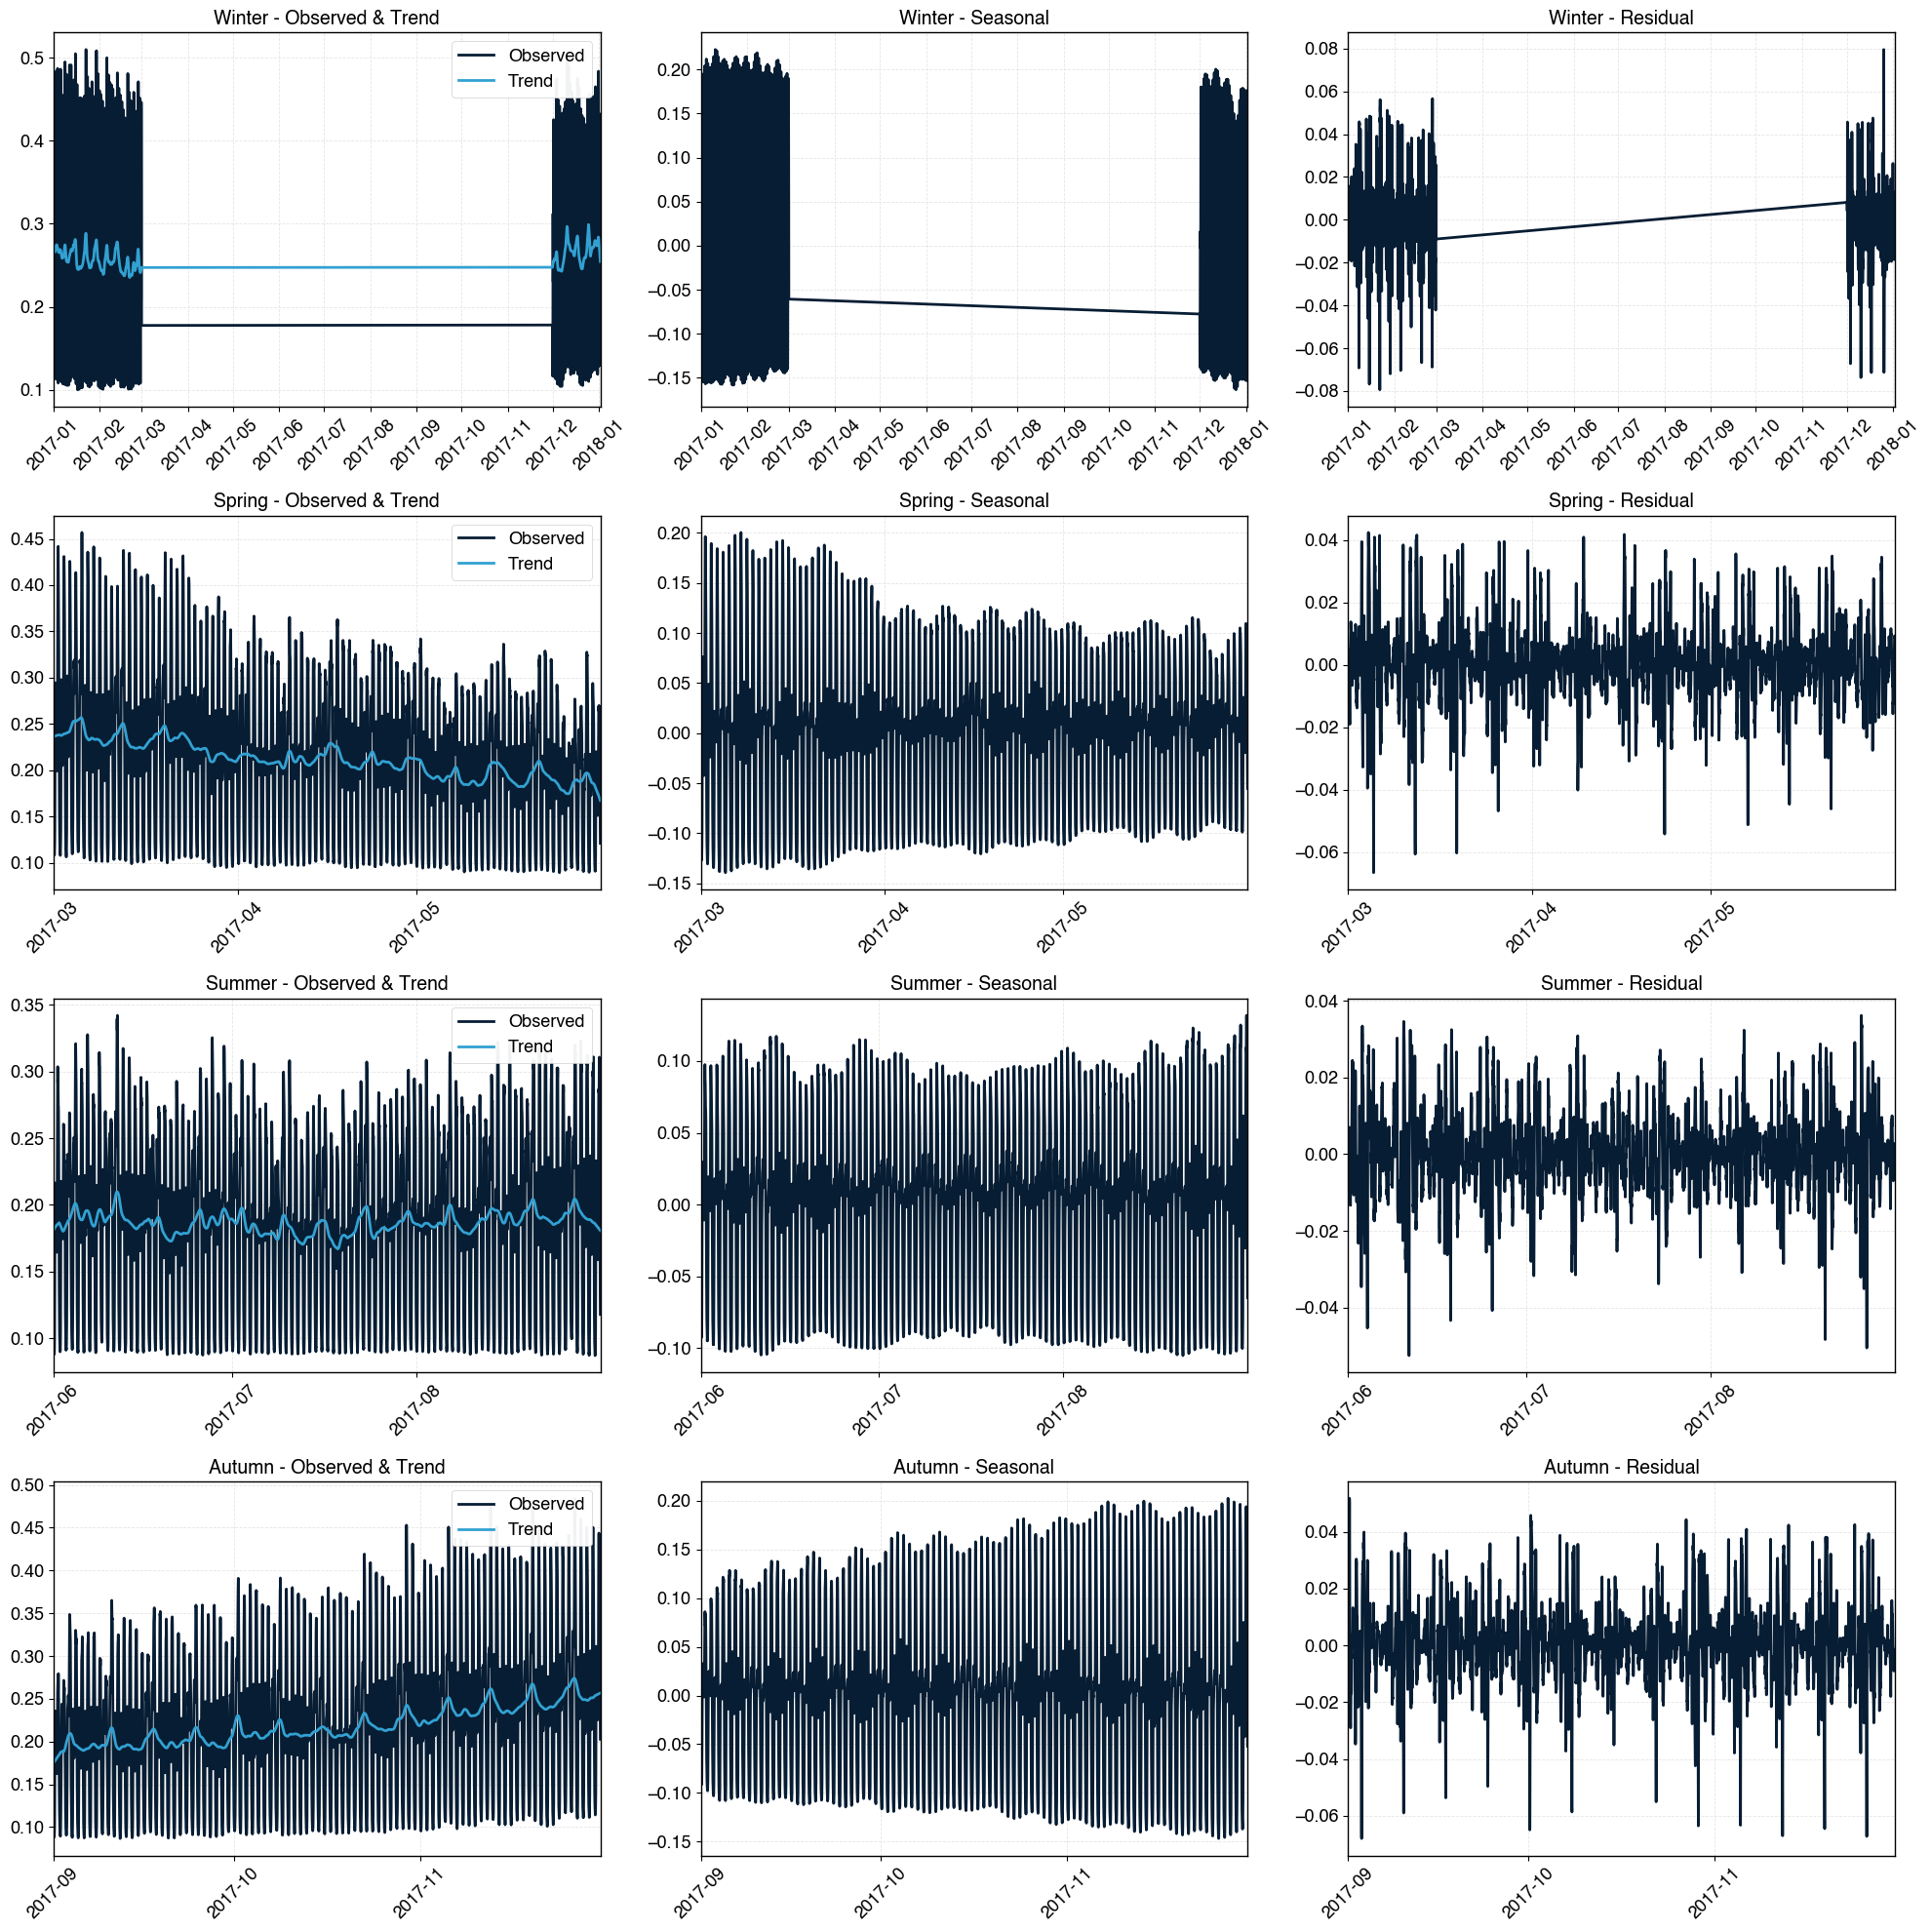

In [215]:
import matplotlib.dates as mdates

seasons = ts_rd['Season'].unique()
fig, axs = plt.subplots(len(seasons), 3, figsize=(20, 20), sharex=False)

for i, season in enumerate(seasons):
    seasonal_df = ts_rd[ts_rd['Season'] == season]
    stl = STL(seasonal_df['Demand_mean_kw'], period=48)
    res = stl.fit()

    # Get start and end for consistent x-axis
    x_start = seasonal_df.index.min()
    x_end = seasonal_df.index.max()

    # Observed + trend
    axs[i, 0].plot(seasonal_df.index, seasonal_df['Demand_mean_kw'], label='Observed')
    axs[i, 0].plot(seasonal_df.index, res.trend, label='Trend')
    axs[i, 0].set_title(f'{season} - Observed & Trend')
    axs[i, 0].legend()

    # Seasonal
    axs[i, 1].plot(seasonal_df.index, res.seasonal)
    axs[i, 1].set_title(f'{season} - Seasonal')

    # Residual
    axs[i, 2].plot(seasonal_df.index, res.resid)
    axs[i, 2].set_title(f'{season} - Residual')

    # Format x-axis for all three
    for ax in axs[i]:
        ax.set_xlim([x_start, x_end])
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

Looking at the STL plots for each season, we can see clear changes in how people use electricity throughout the year. In winter, demand stays pretty steady at first, then shoots up toward the end of the season. The trend line backs that up, showing a big rise in overall usage most likely because it’s colder and darker, so people are using more heating and lights. The seasonal pattern doesn’t really kick in until later in the winter, which could mean more consistent daily routines or heavier use during mornings and evenings. The residuals in winter are a bit all over the place, especially as demand ramps up, suggesting there might have been some unusual events or just more unpredictable usage.

Spring demand decreases slowly as the season ended, this mark the end of spring where weather is getting warmer day by day. We can see it clearly in the seasonal graph.

Summer looks more stable than any other season. the trend doesnt deviate that much as well as the seasonal aspect. This is also suggested by the residual plot where we can see it is between 0.4 and -0.4 where as other season might jump to -0.6 to -0.8.

Autum is the opposite of spring, demand started low and increases towards the end of the season

## Stationary Test

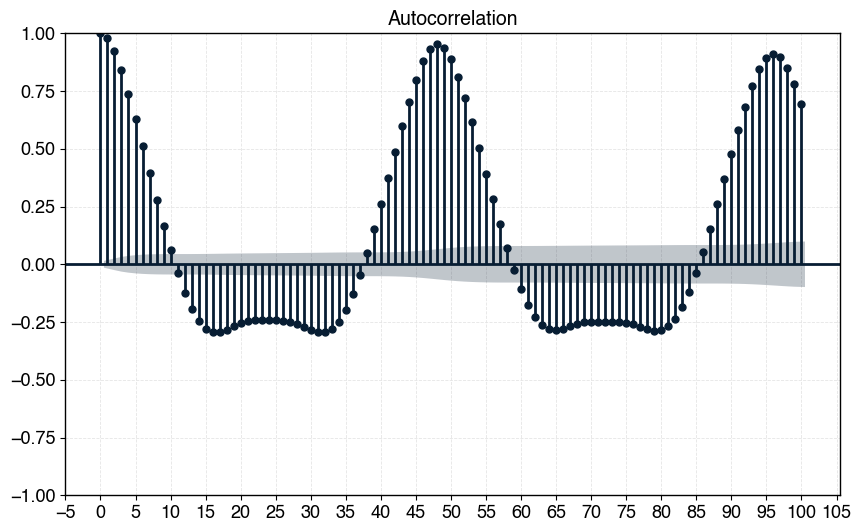

In [216]:
from matplotlib.ticker import MultipleLocator
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size here
#set tick to every 5th value like 0, 5 
plot_acf(ts_rd['Demand_mean_kw'], lags=100, ax=ax)
ax.xaxis.set_major_locator(MultipleLocator(5))
plt.show()

The auto correlation plot shows strong spike at lag 48. This correlate with our data that have interval of 30 minute that means in a day there will be in total 48 points.

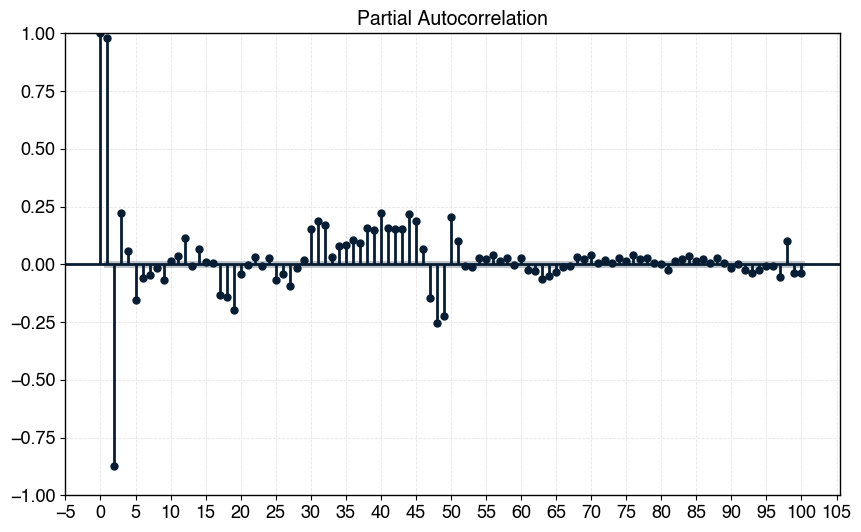

In [217]:
fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size here
plot_pacf(ts_rd['Demand_mean_kw'], lags=100, ax=ax)
ax.xaxis.set_major_locator(MultipleLocator(5))
plt.show()


A spike is present at lag 1 this means that there's a direct, strong positive relationship between the current value and the previous half-hour’s demand. However lag 2 shows a negative strong lag meaning the value two half-hours ago (1 hour ago) pulls the demand in the opposite direction after accounting for lag 1. This suggests that after a short rise in demand, there's often a quick drop like a correction of some sort. 

It might be due to for example, people might switch on appliances or heating for a short period, leading to a spike, but then usage falls soon after as those devices switch off or aren't needed anymore or the device is in idle. This kind of up-and-down pattern in a short time frame is common in residential settings, especially in the morning or evening when people are active for a limited window. The PACF structure points to a model where both lag 1 and lag 2 are important, possibly indicating short term oscillations in usage behavior.

# Energy Consumption

In [218]:
ts_rd['Energy_kwh_per_household'] = ts_rd['Demand_mean_kw'] * 0.5  # Assuming 0.5 households per kW
ts_rd['Energy_kwh_total'] = ts_rd['Energy_kwh_per_household'] * ts_rd['N_households']   # Assuming 1000 households

daily_consumption = ts_rd.groupby("Date")["Energy_kwh_per_household"].sum().reset_index()
avg_daily_consumption = daily_consumption['Energy_kwh_per_household'].mean()
max_consumption = daily_consumption['Energy_kwh_per_household'].max()

print(f"Average daily consumption: {avg_daily_consumption:.2f} kWh")
print(f"Min daily consumption: {daily_consumption['Energy_kwh_per_household'].min():.2f} kWh")
print(f"Max daily consumption: {max_consumption:.2f} kWh")

Average daily consumption: 5.26 kWh
Min daily consumption: 4.01 kWh
Max daily consumption: 7.14 kWh


this is so low?? maybe cause only 41% use electric heating or it is controled? or maybe its a small house. a typical uk energy usage for a flat or 1-bedroom house is 4.93

Possible Appliances that can reach a max 7.14 kWh?:
* Fridge + Freezer 
* Dishwasher
* Oven
* 

# Peak and Off-Peak Hour


In [219]:
ts_rd.head()

,Demand_mean_kw,N_households,Month_int,Date,Season,Energy_kwh_per_household,Energy_kwh_total
Timestamp,,,,,,,
2017-01-01 00:00:00,0.220106,5428,1,2017-01-01,Winter,0.110053,597.3690
2017-01-01 00:30:00,0.205945,5429,1,2017-01-01,Winter,0.102973,559.0380
2017-01-01 01:00:00,0.189090,5429,1,2017-01-01,Winter,0.094545,513.2845
2017-01-01 01:30:00,0.173118,5429,1,2017-01-01,Winter,0.086559,469.9290
2017-01-01 02:00:00,0.159051,5429,1,2017-01-01,Winter,0.079525,431.7430


Mean: 0.22 kW


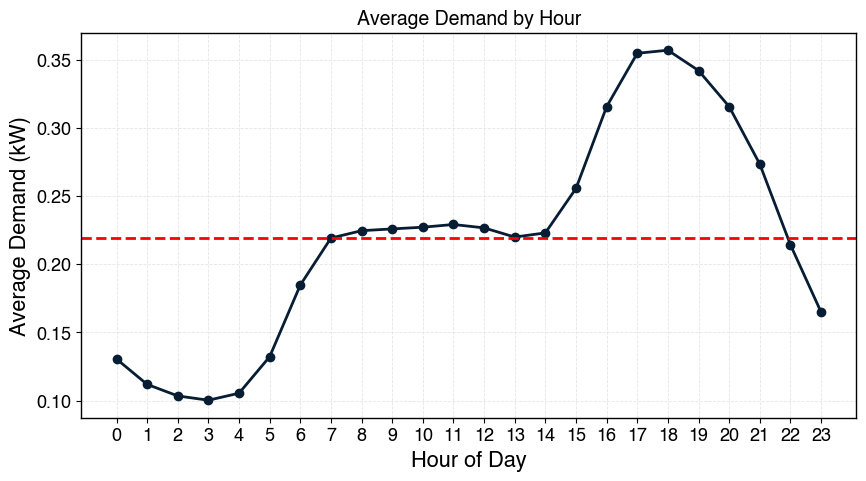

In [220]:
ts_rd['Hour'] = ts_rd.index.hour
ts_rd['Day'] = ts_rd.index.date

hourly_avg = ts_rd.groupby('Hour')['Demand_mean_kw'].mean().reset_index()

print(f'Mean: {hourly_avg["Demand_mean_kw"].mean():.2f} kW')

plt.figure(figsize=(10, 5))
plt.plot(hourly_avg['Hour'], hourly_avg['Demand_mean_kw'], marker='o')
# plot mean line
plt.axhline(y=hourly_avg['Demand_mean_kw'].mean(), color='r', linestyle='--', label='Mean')
plt.title("Average Demand by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Demand (kW)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

## Demand Per Hour For Each Season

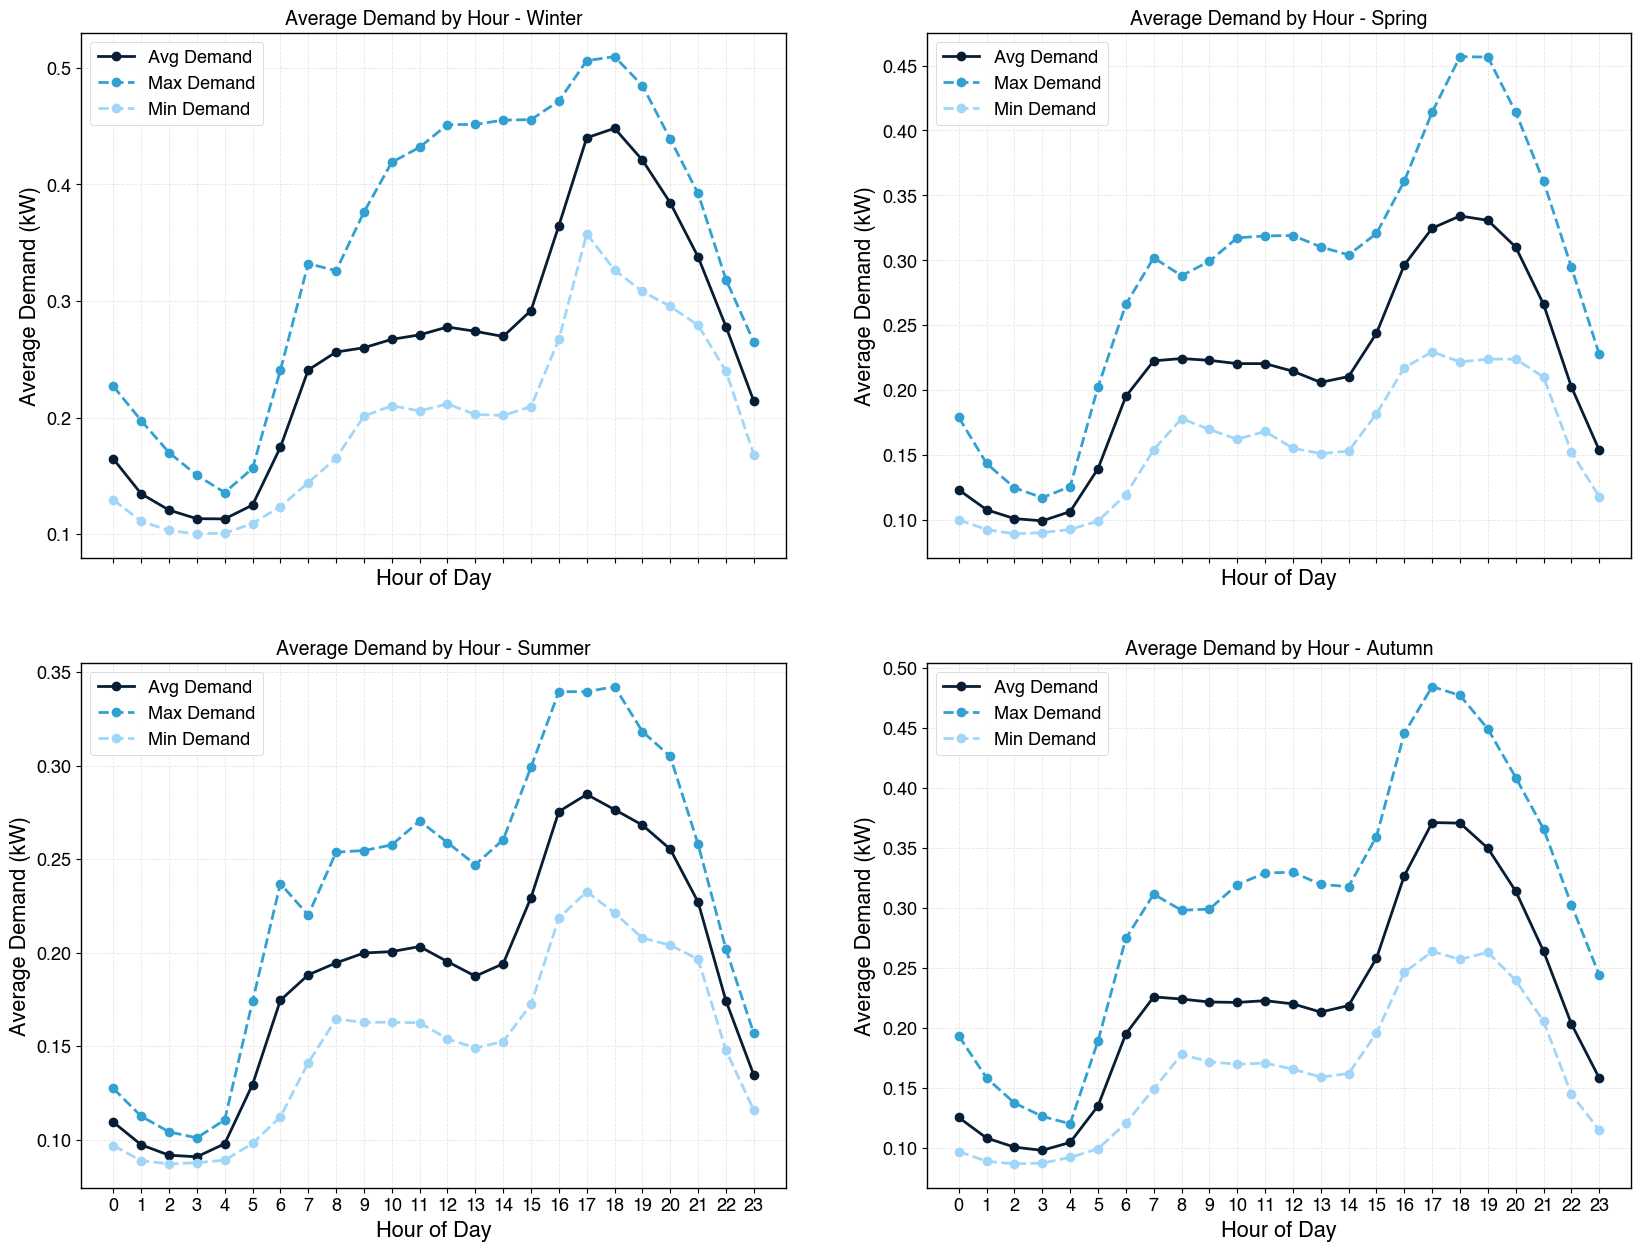

In [221]:
hourly_avg_per_season = ts_rd.groupby(['Hour', 'Season'])['Demand_mean_kw'].mean().unstack()
hourly_avg_per_season = hourly_avg_per_season.reindex(columns=['Winter', 'Spring', 'Summer', 'Autumn'])
max_demand_per_hour_per_season = ts_rd.groupby(['Hour', 'Season'])['Demand_mean_kw'].max().unstack()
max_demand_per_hour_per_season = max_demand_per_hour_per_season.reindex(columns=['Winter', 'Spring', 'Summer', 'Autumn'])
min_demand_per_hour_per_season = ts_rd.groupby(['Hour', 'Season'])['Demand_mean_kw'].min().unstack()
min_demand_per_hour_per_season = min_demand_per_hour_per_season.reindex(columns=['Winter', 'Spring', 'Summer', 'Autumn'])


# Plot the data on seperate subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15), sharex=True)
axs = axs.flatten()
for i, season in enumerate(hourly_avg_per_season.columns):
    axs[i].plot(hourly_avg_per_season.index, hourly_avg_per_season[season], marker='o', label='Avg Demand')
    # Max Demand for the season by hour
    axs[i].plot(max_demand_per_hour_per_season.index, max_demand_per_hour_per_season[season], marker='o', linestyle='--', label='Max Demand')
    # Min Demand for the season by hour
    axs[i].plot(min_demand_per_hour_per_season.index, min_demand_per_hour_per_season[season], marker='o', linestyle='--', label='Min Demand')
    axs[i].legend(loc ='upper left')
    axs[i].set_title(f"Average Demand by Hour - {season}")
    axs[i].set_xlabel("Hour of Day")
    axs[i].set_ylabel("Average Demand (kW)")
    axs[i].grid(True)
    axs[i].set_xticks(range(0, 24))


In [222]:
peak_hours = {}
for i, season in enumerate(hourly_avg_per_season.columns):
    peak_hours_season = hourly_avg_per_season[season][hourly_avg_per_season[season] > (hourly_avg_per_season[season].mean()+0.03)].index.tolist()
    peak_hours[season] = peak_hours_season

    
# Print peak hours for each Season
for season, hours in peak_hours.items():
    print(f"Peak hours for {season}: {hours}")
    print(f'Off-peak hours for {season}: {[h for h in range(0, 24) if h not in hours]}')
    print('')

Peak hours for Winter: [15, 16, 17, 18, 19, 20, 21]
Off-peak hours for Winter: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22, 23]

Peak hours for Spring: [15, 16, 17, 18, 19, 20, 21]
Off-peak hours for Spring: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22, 23]

Peak hours for Summer: [15, 16, 17, 18, 19, 20, 21]
Off-peak hours for Summer: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22, 23]

Peak hours for Autumn: [15, 16, 17, 18, 19, 20, 21]
Off-peak hours for Autumn: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22, 23]



# Clustering

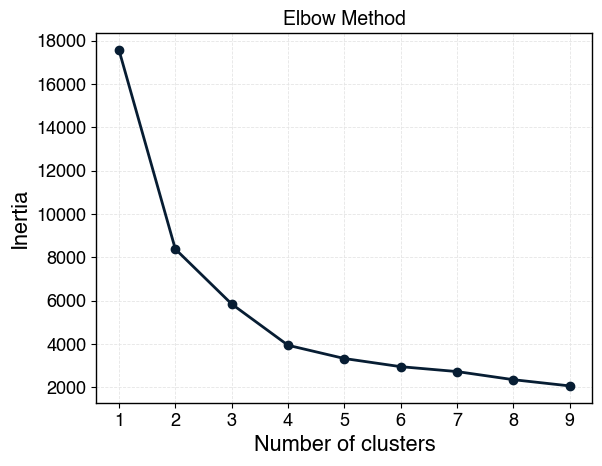

In [223]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

ts_rd['Time'] = ts_rd.index.time  # Extracts time like 00:00:00, 00:30:00, ...
daily_profiles = ts_rd.pivot_table(
    index='Date', columns='Time', values='Demand_mean_kw'
)


X = StandardScaler().fit_transform(daily_profiles.fillna(0))  # or dropna()


inertias = []
K = range(1, 10)
for k in K:
    model = KMeans(n_clusters=k, random_state=0).fit(X)
    inertias.append(model.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


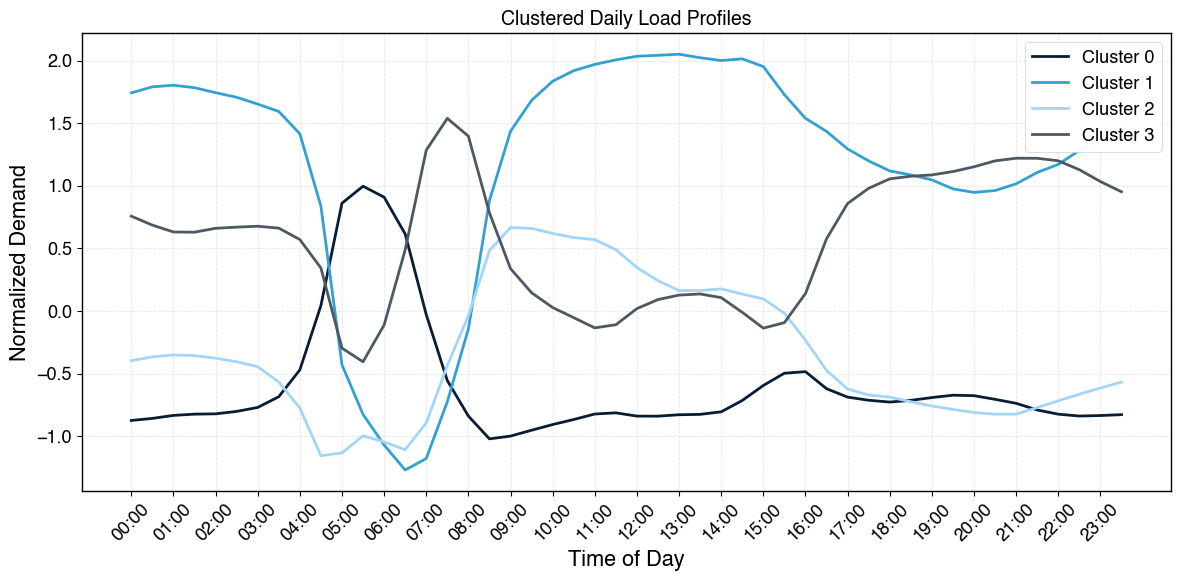

In [224]:
kmeans = KMeans(n_clusters=4, random_state=0)
daily_profiles['cluster'] = kmeans.fit_predict(X)

daily_profiles['cluster'] = kmeans.labels_
daily_profiles = daily_profiles.reset_index()  # This brings 'Date' from index to column
daily_profiles['Date'] = pd.to_datetime(daily_profiles['Date'])

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(kmeans.n_clusters):
    cluster_center = kmeans.cluster_centers_[i]
    plt.plot(cluster_center, label=f'Cluster {i}')
# Set x-axis ticks every hour (i.e., every 2 steps)
x_ticks = np.arange(0, 48, 2)
x_labels = [f'{h:02d}:00' for h in range(24)]

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)

plt.xticks(rotation=45)

ax.set_title('Clustered Daily Load Profiles')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Normalized Demand')
ax.legend()
plt.tight_layout()
plt.show()

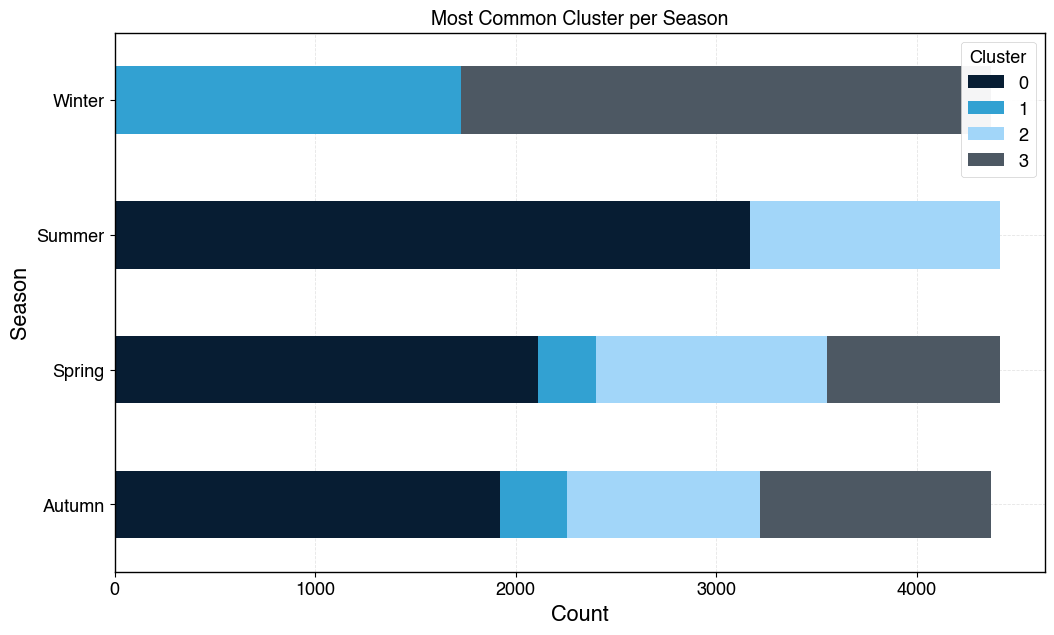

In [ ]:
df_clustered = ts_rd.copy()
# Ensure 'Date' is in both dataframes and properly formatted
df_clustered['Date'] = pd.to_datetime(df_clustered['Date'])

df_clustered = df_clustered.merge(
    daily_profiles[['Date', 'cluster']],
    on='Date',
    how='left'
)


# Most common cluster per season
cluster_season = df_clustered.groupby(['Season', 'cluster']).size().unstack()

fig, ax = plt.subplots(figsize=(12, 7))

cluster_season.plot(kind='barh', stacked=True, ax=ax)
ax.set_title('Most Common Cluster per Season')
ax.set_xlabel('Count')
ax.set_ylabel('Season')
ax.legend(title='Cluster')
plt.show()





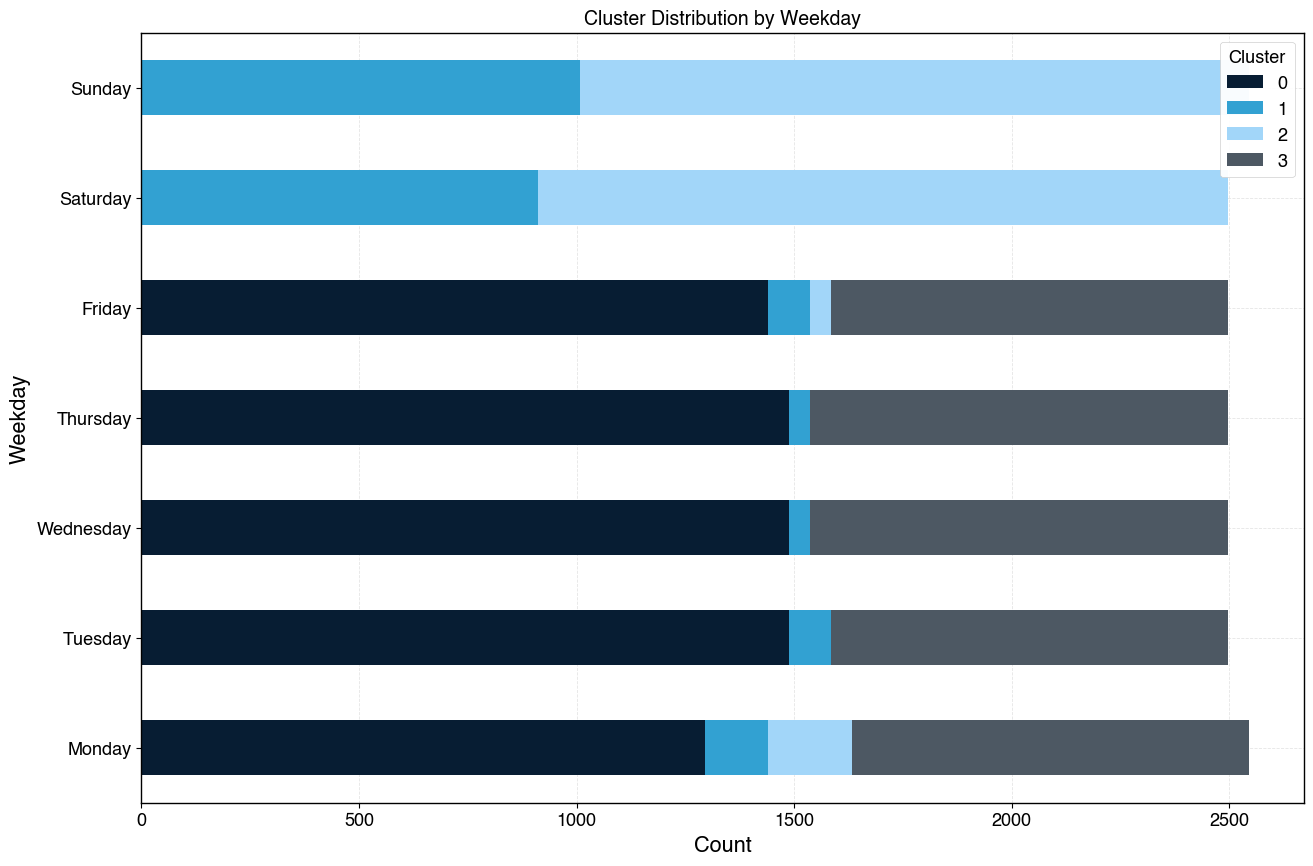

In [226]:
# Cluster counts per weekday
df_clustered['weekday'] = pd.to_datetime(df_clustered['Date']).dt.day_name()

cluster_weekday = df_clustered.groupby(['weekday', 'cluster']).size().unstack().loc[
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
]

fig, ax = plt.subplots(figsize=(15,10))

cluster_weekday.plot(kind='barh', stacked=True, ax=ax)
ax.set_title('Cluster Distribution by Weekday')
ax.set_ylabel('Weekday')
ax.set_xlabel('Count')
ax.legend(title='Cluster')
# plt.tight_layout()
plt.show()

# Export CSV

In [228]:
# Rename column for clarity
ts_rd_renamed = ts_rd.copy()
ts_rd_renamed.rename(
    columns={
        'Demand_mean_kw': 'res_demand_avg_kw',
        'N_households': 'res_n_households',
        'Month_int': 'month',
        'Date': 'date',
        'Season': 'season',
        'Energy_kwh_per_household': 'res_energy_per_household_kwh',
        'Energy_kwh_total': 'res_energy_total_kwh',
        'Hour': 'hour',
        'Day': 'day',
        'Time': 'time'
    },
    inplace=True
)

In [232]:
# select only the relevant columns
ts_rd_renamed = ts_rd_renamed[['res_demand_avg_kw', 'res_n_households', 'res_energy_per_household_kwh', 'res_energy_total_kwh', 'season', 'hour', 'day']]

ts_rd_renamed.head()

,res_demand_avg_kw,res_n_households,res_energy_per_household_kwh,res_energy_total_kwh,season,hour,day
Timestamp,,,,,,,
2017-01-01 00:00:00,0.220106,5428,0.110053,597.3690,Winter,0,2017-01-01
2017-01-01 00:30:00,0.205945,5429,0.102973,559.0380,Winter,0,2017-01-01
2017-01-01 01:00:00,0.189090,5429,0.094545,513.2845,Winter,1,2017-01-01
2017-01-01 01:30:00,0.173118,5429,0.086559,469.9290,Winter,1,2017-01-01
2017-01-01 02:00:00,0.159051,5429,0.079525,431.7430,Winter,2,2017-01-01


# Residential Demand Data — Final Column Dictionary

| Column Name                    | Data Type  | Unit | Description                                                                                     |
| ------------------------------ | ---------- | ---- | ----------------------------------------------------------------------------------------------- |
| `timestamp`                    | `datetime` | -    | Start time of the 30-minute interval (index of the dataframe).                                  |
| `res_demand_avg_kw`            | `float`    | kW   | Average residential power demand during the interval.                                           |
| `res_n_households`             | `integer`  | -    | Number of residential households connected at that time.                                        |
| `res_energy_per_household_kwh` | `float`    | kWh  | Estimated energy consumed per household in the interval.                                        |
| `res_energy_total_kwh`         | `float`    | kWh  | Total residential energy demand in the interval (`res_demand_avg_kw × 0.5 × res_n_households`). |
| `season`                       | `string`   | -    | Meteorological season (`"Winter"`, `"Spring"`, `"Summer"`, `"Autumn"`).                         |
| `hour`                         | `integer`  | h    | Hour of the day (0–23) corresponding to the timestamp.                                          |
| `day`                          | `date`     | -    | Calendar day of the observation (same as `date`, included if used separately).                  |
| `date`                         | `date`     | -    | Date portion of the timestamp.                                                                  |
| `time`                         | `time`     | -    | Time portion of the timestamp.                                                                  |

#### Residential Data Naming Convention Guidelines

* **snake\_case** is used for all column names for consistency.
* **Prefixes indicate variable context:**

  * `res_` → residential demand or energy usage metrics
* **Suffixes indicate units or data type:**

  * `_kw` → kilowatts (average power)
  * `_kwh` → kilowatt-hours (energy consumption)
  * `_n` → counts (e.g., number of households)
* **Time-related columns** follow lowercase standard (`timestamp`, `date`, `hour`, `time`).
* Column names prioritize clarity and traceability:

  * `res_energy_per_household_kwh` → energy use per household
  * `res_energy_total_kwh` → total energy across all households
  * `res_demand_avg_kw` → average power demand in the interval

Booleans are not currently used in this dataset, but if added, follow the structure `is_<status>` or `<context>_is_<status>`.

In [234]:
ts_rd_renamed.to_csv(PROCESSED_DATASET_PATH / '250411_residential_demand_dataset_v1.csv', index=True)